# Cosine Similarity and Pearson's Correlation Coefficient
- ### Daily precipitation for one month
- ### 270 gauges
- ### Two points chosen for comparison - one in center, one in mountains

In [1]:
library('dplyr')
library('sp')
library('reshape2')
options(repr.plot.width=5, repr.plot.height=5)
options(warn = -1)
# ---------------------------------
# Load data and metadata
# ---------------------------------
setwd(paste0('/home/micha/Studies/Courses',
             '/Geostatistics-Tal/Project/'))

date_str_from <- '20170101'
date_str_to <- '20170131'
data_file <- paste0('gauge_data/','gauge_data_daily.csv')
data_cols <- c('station_id','date_time','quality',
                 'obs_precip', 'precip_ind','snow','eor')

gauge_data <- read.csv(data_file, col.names=data_cols)

meta_cols <- c('station_id','from_date','to_date','elevation',
               'latitude','longitude',
               'stn_name','province')
gauge_metadata <- read.csv('gauge_data/gauge_metadata_bavaria.csv', col.names=meta_cols)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Data.frame for all of January
gauges_jan17 <- filter(gauge_data, 
                              date_time >= date_str_from & date_time <= date_str_to)


gauges_jan17 <- merge(gauges_jan17, gauge_metadata, by='station_id', all.y=TRUE)
# Make sure to clean out NA or < 0 (unknown values)
gauges_jan17 <- na.omit(gauges_jan17)
gauges_jan17 <- filter(gauges_jan17, obs_precip>=0)

# Get one day (or hour), and attach metadata, for plotting
gauges <- filter(gauge_data,
                 date_time == date_str_from)
gauges <- merge(gauges, gauge_metadata, by='station_id', all.y=TRUE)

## gauge locations
<img src="CosSim_map.png" alt="Gauges Map" style="width: 800px;"/>

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=49,11.5&zoom=7&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false


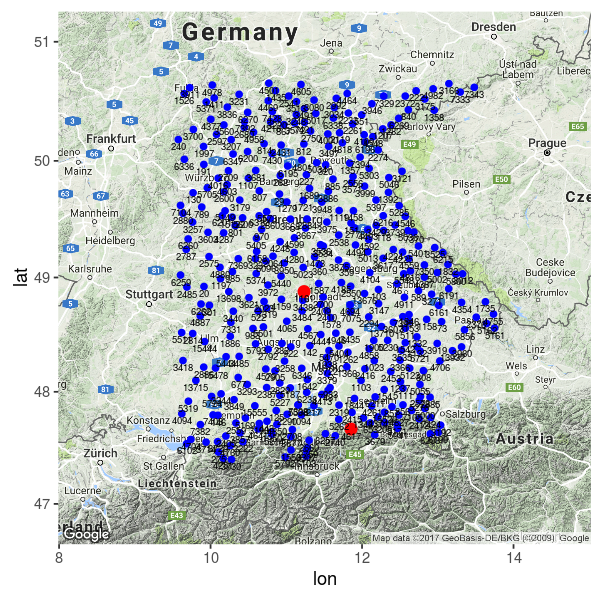

In [3]:
# ---------------------------------
# Show gauges on a map
# ---------------------------------
library('ggplot2')
library('ggmap')

bavaria_map <- get_map(location = c(11.5,49), zoom=7)

# Select test gauge
# Subset out the two test gauges, to plot in red
test_gauge1 <- '1161'     # Center of region
test_gauge2 <- '4617'   # In the mountains
select_gauges <- subset(gauges, station_id %in% c(test_gauge1,test_gauge2))
ggmap(bavaria_map) + 
  geom_point(data=gauges, aes(x=longitude, y=latitude), 
             col="blue", size=1.5) +
  geom_point(data=select_gauges, aes(x=longitude, y=latitude),
             col="red", size=3) +
  geom_text(aes(label=station_id, x=longitude, y=latitude, vjust=1.5), 
            size=2, data=gauges)

## Use cast() to make a wide data frame
- ### 31 rows of daily precipitation
- ### 270 columns, one for each gauge

In [4]:
# Create "Wide" matrix with one row for each day, 270 columns of precip data 
gauges_precip = as.data.frame(acast(gauges_jan17, date_time~station_id, value.var="obs_precip"))
head(gauges_precip)

,20,73,103,118,130,142,151,154,191,205,⋯,7424,7428,7430,7431,13698,13710,13715,15444,15478,15555
20170101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170102,1.4,2.9,2.0,1.5,1.3,3.3,0.8,4.4,0.8,7.0,⋯,1.9,2.4,1.4,3.8,0.8,2.9,2.8,0.7,3.3,2.7
20170103,0.4,0.9,0.4,4.9,0.3,0.0,2.3,0.0,0.2,0.0,⋯,0.0,7.8,1.8,0.0,0.0,0.1,0.1,0.0,0.0,0.0
20170104,3.9,1.4,5.5,2.5,3.5,3.2,4.0,2.3,1.8,17.2,⋯,10.0,5.5,2.6,2.8,2.8,3.7,1.2,1.2,3.0,2.3
20170105,0.0,0.0,0.0,0.2,0.0,0.1,0.1,0.8,0.1,10.0,⋯,3.1,0.8,0.0,0.8,0.0,0.8,0.5,0.7,0.6,0.4
20170106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,⋯,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# How is cosine similarity related to correlation coefficient ($R^2$)
### Cosine Similarity
$$ cos(\theta) = \frac{\sum_{i} (x_{i}*y_{i})} {\sqrt{\sum_{i}x_{i}^2} * \sqrt{\sum_{i}y_{i}^2}} $$

### Correlation Coefficient ($ R^2 $)
$$ \rho(x,y) = \frac{\sum_{i}(x_{i} - \bar{x})*(y_{i} - \bar{y})}{\sqrt{\sum_{i}(x_{i} - \bar{x})^2}*\sqrt{\sum_{i}(y_{i} - \bar{y})^2}} = \frac{cov(x,y)}{\sigma_{x}*\sigma_{y}} $$


In [5]:
# Function for cosine similarity index
cosine_similarity <- function(x,y) {
  # x, y are vectors
  sum_xy <- sum(x*y)
  sum_x2 <- sum(x^2)
  sum_y2 <- sum(y^2)
  csi <- (sum_xy)/(sqrt(sum_x2)*sqrt(sum_y2))
  return(csi)
}

In [6]:
# Loop thru gauges_precip 
# and calculate cosine similarity
cos_sim1 <- as.data.frame(matrix(ncol=1, nrow=dim(gauges_precip)[2]),
                       row.names = colnames(gauges_precip))
cos_sim2 <- as.data.frame(matrix(ncol=1, nrow=dim(gauges_precip)[2]), 
                       row.names = colnames(gauges_precip))

#Use rownames to add column for station_id
cos_sim1$station_id <- rownames(cos_sim1)
cos_sim2$station_id <- rownames(cos_sim2)
# Setup column names
colnames(cos_sim1) <- c('CosSim1','station_id')
colnames(cos_sim2) <- c('CosSim2','station_id')

for (i in colnames(gauges_precip)) {
  cos_sim1[i,]$CosSim1 <- cosine_similarity(gauges_precip[i], gauges_precip[test_gauge1])
  cos_sim2[i,]$CosSim2 <- cosine_similarity(gauges_precip[i], gauges_precip[test_gauge2])
}

In [7]:
# and calculate correlation coefficient 
corr_coef1 <- as.data.frame(cor(gauges_precip, gauges_precip[test_gauge1]))
corr_coef2 <- as.data.frame(cor(gauges_precip, gauges_precip[test_gauge2]))
#Use rownames to add column for station_id
corr_coef1$station_id <- rownames(corr_coef1)
corr_coef2$station_id <- rownames(corr_coef2)
colnames(corr_coef1) <- c('Rsquared1','station_id')
colnames(corr_coef2) <- c('Rsquared2','station_id')

In [8]:
# Now plot correlation coefficients and cosine similarities
options(repr.plot.width=9, repr.plot.height=5)
library(gridExtra)
library(RColorBrewer)
clrs <- brewer.pal(name='RdYlBu', n=6)

gauges <- merge(gauges, corr_coef1, by='station_id', all.y=TRUE)
gauges <- merge(gauges, corr_coef2, by='station_id', all.y=TRUE)
gauges <- merge(gauges, cos_sim1, by='station_id', all.y=TRUE)
gauges <- merge(gauges, cos_sim2, by='station_id', all.y=TRUE)

#Pair of maps for first test point
map1 <- ggmap(bavaria_map) + 
  geom_point(data=gauges, aes(x=longitude, y=latitude, colour=Rsquared1), 
              size=2) +
  scale_color_gradientn(colours = clrs) +
  theme(legend.text = element_text(size = 8),
        legend.title = element_text(size=10))
map2 <- ggmap(bavaria_map) + 
  geom_point(data=gauges, aes(x=longitude, y=latitude, colour=CosSim1), 
             size=2) +
  scale_color_gradientn(colours = clrs) +
  theme(legend.text = element_text(size = 8),
        legend.title = element_text(size=10))

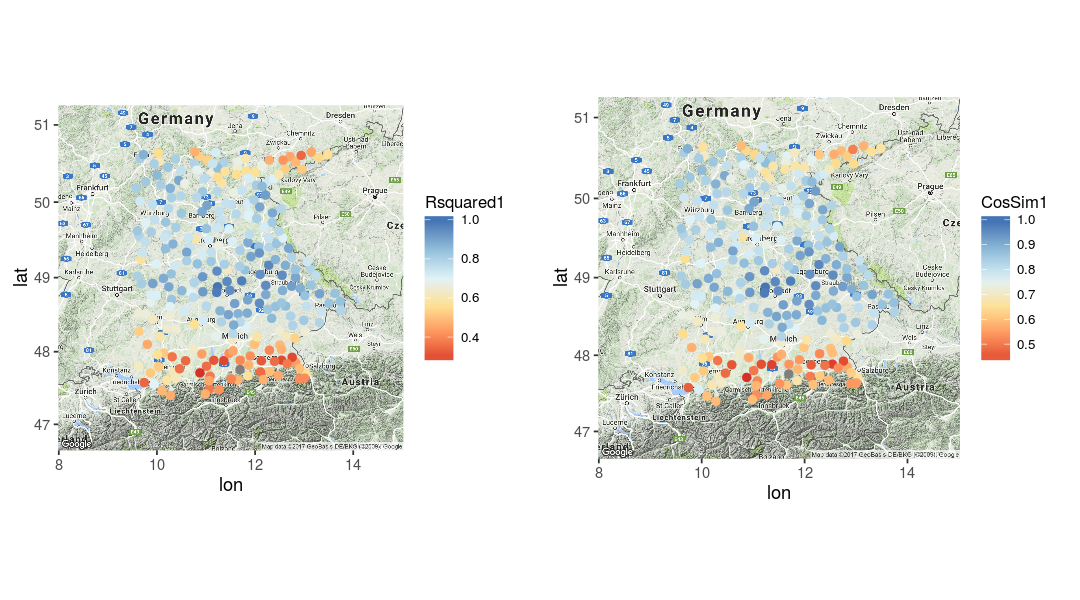

In [9]:
grid.arrange(map1, map2, nrow=1)

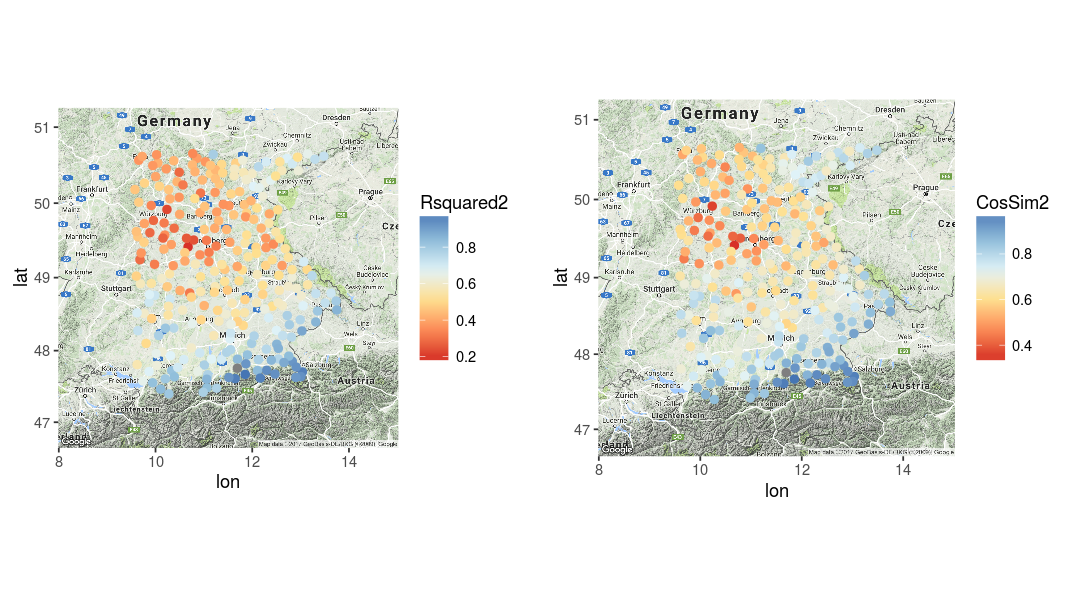

In [10]:
# Pair of maps for second test point
map3 <- ggmap(bavaria_map) + 
  geom_point(data=gauges, aes(x=longitude, y=latitude, colour=Rsquared2), 
             size=2) +
  scale_color_gradientn(colours = clrs)
map4 <- ggmap(bavaria_map) + 
  geom_point(data=gauges, aes(x=longitude, y=latitude, colour=CosSim2), 
             size=2) +
  scale_color_gradientn(colours = clrs)
grid.arrange(map3, map4, nrow=1)

## R squared and Cosine Similarity
### First chosen gauge point
<img src="Rsq_CosSim1.png" alt="Cosine Similarity" style="width: 1000px;"/>

### Second chosen gauge point¶
<img src="Rsq_CosSim2.png" alt="Cosine Similarity" style="width: 1000px;"/>

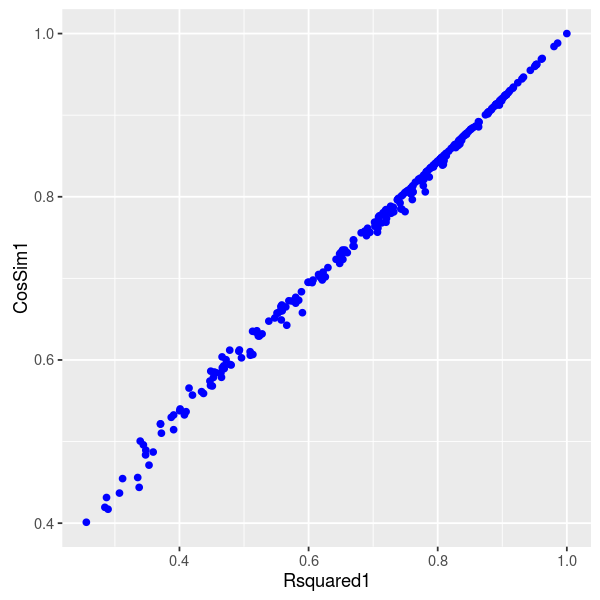

In [11]:
# And scatter plot of R squared vs Cosine Similarity
options(repr.plot.width=5, repr.plot.height=5)
ggplot(data=gauges) + geom_point(aes(x=Rsquared1, y=CosSim1), col='Blue')

## Are any gauges redundant?

In [12]:
# Candidates for redundant gauges: 
subset(gauges, Rsquared1>=0.95 & CosSim1>=0.95)

,station_id,date_time,quality,obs_precip,precip_ind,snow,eor,from_date,to_date,elevation,latitude,longitude,stn_name,province,Rsquared1,Rsquared2,CosSim1,CosSim2
3,103,20170101,3,0,0,0,eor,20040701,20170316,364,48.8960,12.2170,Hagelstadt,Bayern,0.9534897,0.5183255,0.9622614,0.6284097
39,1161,20170101,3,0,0,0,eor,20050201,20170316,384,48.8777,11.2349,Eichsttt-Landershofen,Bayern,1.0000000,0.5694957,1.0000000,0.6725318
57,1587,20170101,3,0,4,-999,eor,19800825,20170316,536,48.9481,11.4289,Gelbelsee,Bayern,0.9606096,0.5256775,0.9686307,0.6438987
70,2294,20170101,3,0,0,0,eor,20040701,20170316,470,48.6573,12.0888,Hohenthann,Bayern,0.9523331,0.5772412,0.9614510,0.6931927
88,2700,20170101,3,0,0,0,eor,20041201,20170316,416,48.8302,11.4872,Ksching,Bayern,0.9501844,0.4673586,0.9597326,0.5915229
119,3438,20170101,3,0,0,0,eor,20041201,20170316,401,48.8016,11.2181,Nassenfels,Bayern,0.9857113,0.4963202,0.9882886,0.6121632
127,3617,20170101,3,0,0,0,eor,20050101,20170316,430,49.1659,12.2788,Nittenau-Harting,Bayern,0.9618696,0.4859388,0.9695327,0.6199809
155,4185,20170101,3,0,0,0,eor,20040901,20170316,363,48.9557,11.7278,Riedenburg,Bayern,0.9801253,0.5066919,0.9841406,0.6278331
192,5023,20170101,3,0,0,0,eor,20021101,20170316,417,49.0871,11.2236,Thalmssing,Bayern,0.9529570,0.5460100,0.9622789,0.6676440
216,5548,20170101,3,0,0,-999,eor,20040701,20170316,680,49.0321,12.5504,Wiesenfelden-Utzenzell,Bayern,0.9521483,0.5102383,0.9618093,0.6393725


In [13]:
options(warn = 0)